In [2]:
import cv2 as cv 
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from PIL import Image

from PIL import Image, ImageDraw, ImageFilter
from matplotlib import pyplot as plt

# draw a blank image, default value of 512x512 with color white or black
def draw_blank_image(x=512,y=512, isWhite=False):
    img = np.zeros([x,y,3], dtype=np.uint8)
    if(isWhite):
        img.fill(255)
    else:
        img.fill(0)
    return img

# draw grid on an image, e.g. blank image 
# #https://stackoverflow.com/questions/44816682/drawing-grid-lines-across-the-image-using-opencv-python
def draw_grid_rect(img=draw_blank_image(), grid_shape=(16,16), color=(255,255,255), thickness=1):
    h, w, _ = img.shape
    rows, cols = grid_shape
    dy, dx = h / rows, w / cols

    # draw vertical lines
    for x in np.linspace(start=dx, stop=w-dx, num=cols-1):
        x = int(round(x))
        cv.line(img, (x, 0), (x, h), color=color, thickness=thickness)

    # draw horizontal lines
    for y in np.linspace(start=dy, stop=h-dy, num=rows-1):
        y = int(round(y))
        cv.line(img, (0, y), (w, y), color=color, thickness=thickness)

    return img

# draw radial grid
def draw_grid_radial(img=draw_blank_image(), n_radial=6, multiplier=2, color=(255,255,255), thickness=1):
    h, w, _ = img.shape
    isWider = True
    x_adjust = 0
    y_adjust = 0

    
    radius = min(h,w)/2
    x_center = w/2
    y_center = h/2
    
    # for each radial range, such as 0, 60, 120 etc (converted to radian), draw a line
    for i in range(0,n_radial+1):
        theta = 2*math.pi/n_radial*i
        # print('theta = '+str(theta))
        x1 = int(x_center + multiplier*radius * math.cos(theta))
        x2 = int(x_center - multiplier*radius * math.cos(theta))
        y1 = int(y_center + multiplier*radius * math.sin(theta))
        y2 = int(y_center - multiplier*radius * math.sin(theta))
        # print(str(x1)+", "+str(y1)+", "+str(x2)+", "+str(y2))
        cv.line(img, (x1,y1), (x2,y2), color=color, thickness=thickness)
    return img

def show_rgb_image(image, title=None, conversion=cv.COLOR_BGR2RGB):

    # Converts from one colour space to the other. this is needed as RGB
    # is not the default colour space for OpenCV
    image = cv.cvtColor(image, conversion)

    # Show the image
    plt.imshow(image)

    # remove the axis / ticks for a clean looking image
    plt.xticks([])
    plt.yticks([])

    # if a title is provided, show it
    if title is not None:
        plt.title(title)

    plt.show()

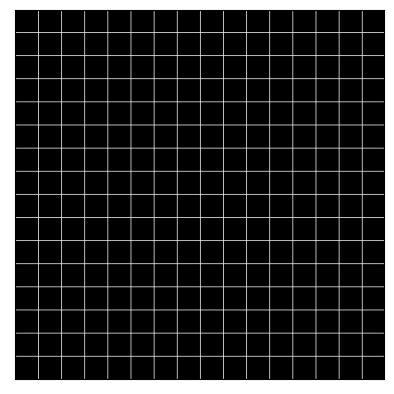

In [3]:
blank = draw_blank_image(isWhite=False)
grid_rect = draw_grid_rect()

show_rgb_image(grid_rect)

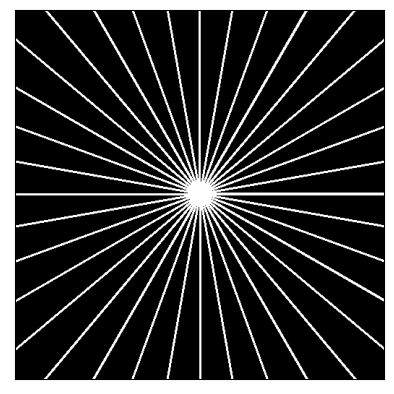

In [4]:
grid_radial = draw_grid_radial(n_radial=36, thickness=2)
show_rgb_image(grid_radial)


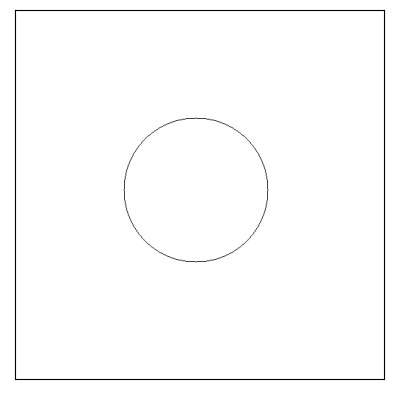

In [5]:
img_circle = draw_blank_image(isWhite=True)
cv.circle(img=img_circle, center = (250,250), radius =100, color =(0,0,0), thickness=1)

show_rgb_image(img_circle)

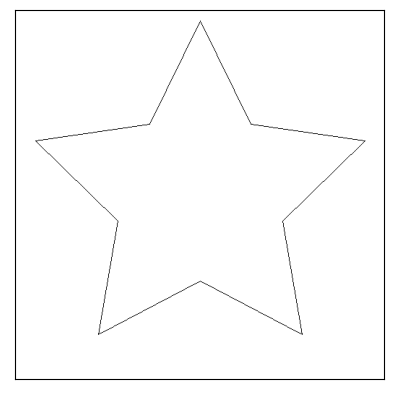

In [6]:
from math import pi, cos, sin
img_star = draw_blank_image(isWhite=True)

# (rcos(2πk/5+π/2),rsin(2πk/5+π/2))∣k=0,...,4

def coord_star(r = 4):
    multiplier = 2*pi/5
    shifter = pi/2
    coord = []
    # generate the 5*2 coordinates of 5 pointed star
    for i in range(5):
        x , y = r*cos(multiplier*i+shifter), r*sin(multiplier*i+shifter)
        coord.append((x, y))
        x , y = 2*r*cos(multiplier*i+shifter+2*pi/10), 2*r*sin(multiplier*i+shifter+2*pi/10)
        coord.append((x, y))

    # duplicate the first element at the end, to ensure close form of shape
    coord.append(coord[0])
    # shift to center by the size of image/2
    center = 256
    return np.array(coord).astype(int) + center

star = coord_star(120)

# (star[i][0], star[i][1]), (star[i+1][0], star[i+1][1])

for i in range(len(star)-1):
    img_star = cv.line(img_star, (star[i][0], star[i][1]), (star[i+1][0], star[i+1][1]) , color =(0,0,0), thickness=1)

# img_star = cv.line(img_star, (0,0), (100,100) , color =(255,0,0), thickness=1)

show_rgb_image(img_star)

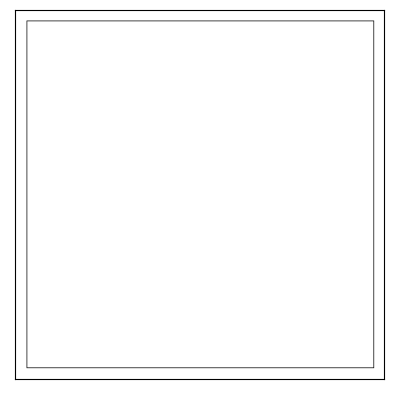

In [7]:
distance = 16
img_rect = draw_blank_image(isWhite=True)
w, h, _ = img_rect.shape
cv.rectangle(img=img_rect, pt1=(distance,distance),pt2=(w-distance,h-distance), color =(0,0,0), thickness=1)

show_rgb_image(img_rect)

In [8]:
def mergeImageGrid(img, grid):
    img_grid = Image.fromarray(grid)
    img_target = Image.fromarray(img)

    img_blank = Image.fromarray(draw_blank_image(isWhite=True))
    img_mask = img_grid.convert("L").resize(img_grid.size)
    return Image.composite(img_target, img_blank, img_mask)



In [9]:
# filter redundant x and y coordinates, i.e that is very close to each other
def filterXY(df, cutoff=3):
    distances = np.sqrt(np.sum([(df[[c]].to_numpy() - df[c].to_numpy())**2 for c in ('x','y')], axis=0))
    mask = np.tril(distances < cutoff, k=-1).any(axis=1)
    return df[~mask]

# retrieve filtered x and y coordinates
def xyFromPILImage(image):
    img_np = np.array(image)
    x, y = np.where((img_np[:,:,0:3] == [0,0,0]).all(2))

    df = pd.DataFrame({'x':x, 'y':y})
    df = filterXY(df)
    df.plot('x','y',kind='scatter')
    return df



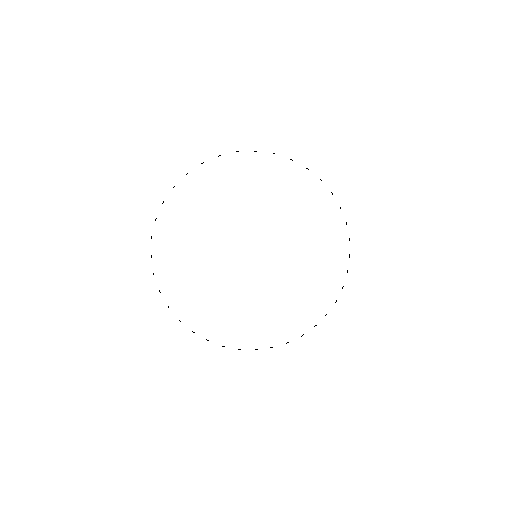

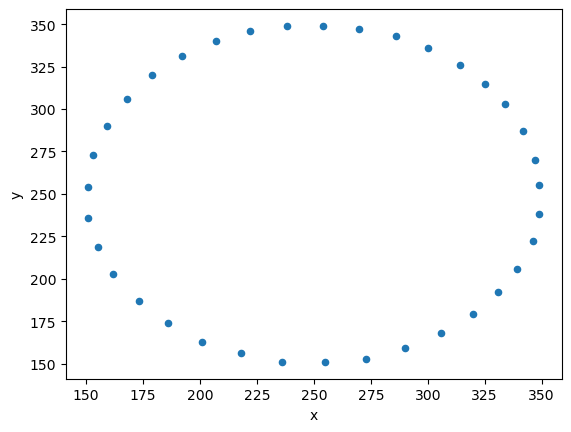

In [10]:
im = mergeImageGrid(img_circle, grid_radial)
display(im)
df_circle = xyFromPILImage(im)

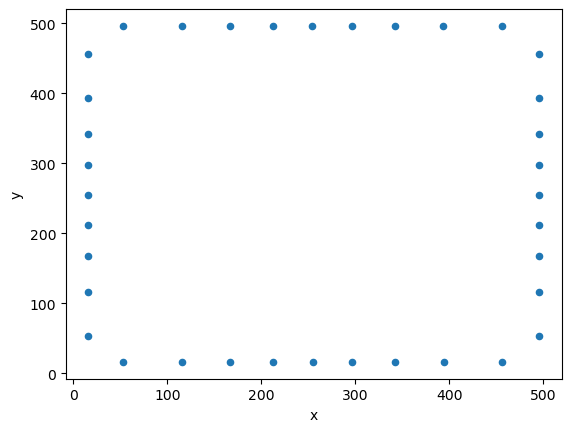

In [11]:
im2 = mergeImageGrid(img_rect, grid_radial)
df_rect = xyFromPILImage(im2)
df_rect.to_csv('coordinates/square.csv', index=False)

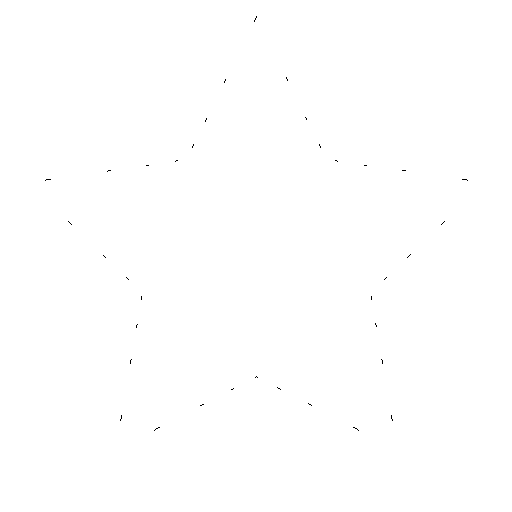

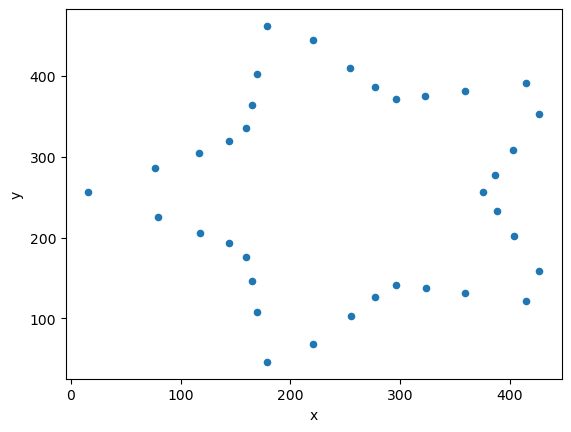

In [12]:
im3 = mergeImageGrid(img_star, grid_radial)
display(im3)
df_star = xyFromPILImage(im3)
df_star.to_csv("coordinates/star.csv", index=False)

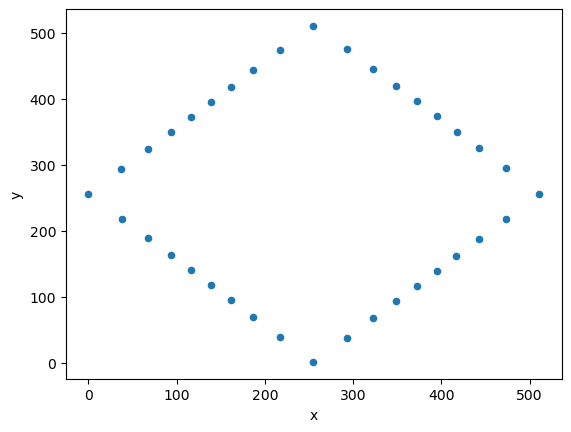

In [13]:
img_diamond = draw_blank_image(isWhite=True)

coord = [[0,256], [256, 512], [512, 256], [256, 0], [0,256]]

for i in range(len(coord)-1):
    img_diamond = cv.line(img_diamond, (coord[i][0], coord[i][1]), (coord[i+1][0], coord[i+1][1]), color=(0,0,0) )


im2 = mergeImageGrid(img_diamond, grid_radial)
df_diamond = xyFromPILImage(im2)
df_diamond.to_csv('coordinates/diamond.csv', index=False)

In [ ]:
coord = [[10,250], [10, 500], [250, 500], [250, 250], [250, 10], [500, 10], [500, 500]]


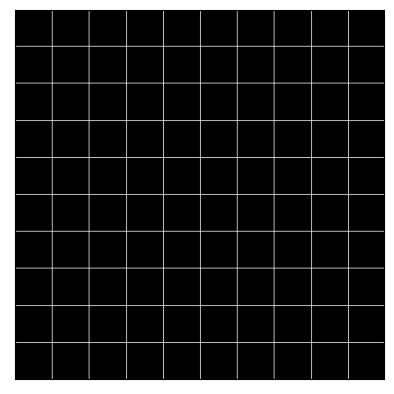

In [40]:
blank2 = draw_blank_image(isWhite=False)
grid_custom = draw_grid_rect(img=blank2, grid_shape=(10,10))

show_rgb_image(grid_custom)

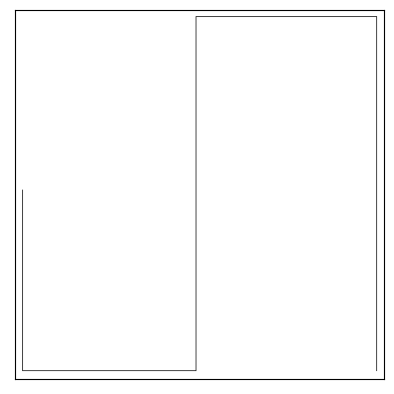

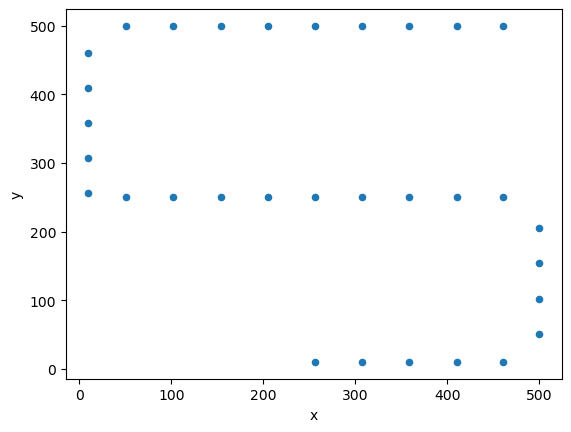

In [42]:
img_custom = draw_blank_image(isWhite=True)

coord = [[10,250], [10, 500], [250, 500], [250, 250], [250, 10], [500, 10], [500, 500]]

for i in range(len(coord)-1):
    img_custom = cv.line(img_custom, (coord[i][0], coord[i][1]), (coord[i+1][0], coord[i+1][1]), color=(0,0,0) )

# coord = [[0,0], [16, 16]]

# for i in range(len(coord)-1):
#     img_custom = cv.line(img_custom, (coord[i][0], coord[i][1]), (coord[i+1][0], coord[i+1][1]), color=(0,0,0) )

show_rgb_image(img_custom)

im2 = mergeImageGrid(img_custom, grid_custom)
df_diamond = xyFromPILImage(im2)
df_diamond.to_csv('coordinates/d4.csv', index=False, mode="x")

In [5]:
import skimage.io
import skimage.measure
import numpy as np
import scipy.interpolate
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def get_coordinates(image_path, threshold=0.5, num_points=36):
    image = skimage.io.imread(image_path, as_gray=True)

    #binary - black:0 , white: 1
    mask = image < threshold

    #contours
    contours = skimage.measure.find_contours(mask, 0.5)
    coordinates = contours[0]

    #resample to target number of points only
    tck, u = scipy.interpolate.splprep([coordinates[:, 1], coordinates[:, 0]], s=0)
    u_new = np.linspace(u.min(), u.max(), num_points)
    x_new, y_new = scipy.interpolate.splev(u_new, tck)
    coordinates = np.column_stack((y_new, x_new))

    #shift the coordinates to be within frame range 0-500
    x_min, y_min = np.min(coordinates, axis=0)
    x_max, y_max = np.max(coordinates, axis=0)
    x_shift = 250 - (x_max + x_min) // 2
    y_shift = 250 - (y_max + y_min) // 2
    coordinates[:, 0] += x_shift
    coordinates[:, 1] += y_shift

    #ensure whole number
    coordinates = np.round(coordinates).astype(int)

    #ensure no duplicates, should be before resample, commented out
    #coordinates = np.unique(coordinates, axis=0)

    #store coordinates in csv
    df = pd.DataFrame(cotoordinates, columns=['x', 'y'])
    df.to_csv('coordinates/'+os.path.splitext(os.path.basename(image_path))[0]+'.csv', index=False, mode="w")

    #return as np array
    return coordinates

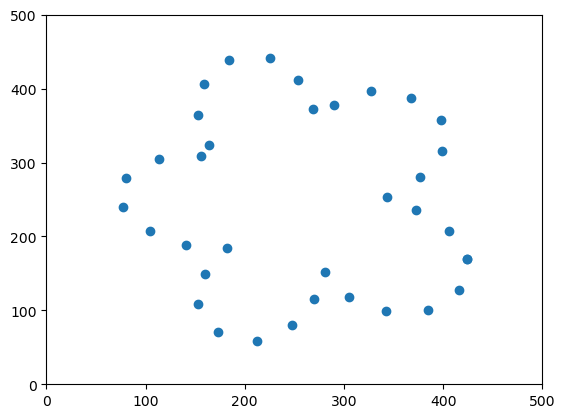

In [6]:
coordinates = get_coordinates('img/flower.PNG')

plt.scatter(coordinates[:, 0], coordinates[:, 1])
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.show()

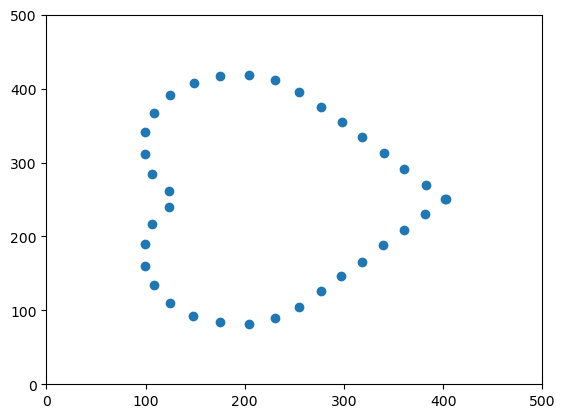

In [8]:
coordinates = get_coordinates('img/love.PNG')

plt.scatter(coordinates[:, 0], coordinates[:, 1])
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.show()

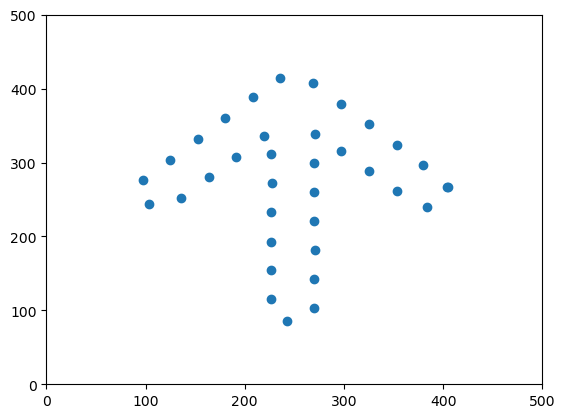

In [10]:
coordinates = get_coordinates('img/arrow.PNG')

plt.scatter(coordinates[:, 0], coordinates[:, 1])
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.show()